### Michael Beven - 455613
### University of Chicago - Financial Mathematics
### FINM 33150 - Quantitative Strategies and Regression
### Homework 3

#### Tables and column descriptions

* **The strategy dataframe**: 
 * ``` XP ``` ~ Adjusted price of security X
 * ``` XV ``` ~ Adjusted volume of security X
 * ``` YP ``` ~ Adjusted price of security Y
 * ``` YV ``` ~ Adjusted volume of security Y
 * ``` XDDV ``` ~ Daily dollar volume of security X
 * ``` Nt ``` ~ 15 day rolling median of ``` XDDV ```
 * ``` XR ``` ~ Log return of X
 * ``` YR ``` ~ Log return of Y
 * ``` Delta ``` ~ ``` XR ``` - ``` YR ```
 * ``` DeltaM ``` ~ M day sume of ``` Delta ```
 * ``` Signal ``` ~ Buy, short, exit signal (-1, 0 or 1)
 * ``` EOM ``` ~ End of month indicator
 * ``` Entry ``` ~ Entry day indicator
 * ``` Exit ``` ~ Exit day indicator
 * ``` Nx ``` ~ Number of X shares bought/shorted
 * ``` Ny ``` ~ Number of Y shares bought/shorted
 * ``` Profit ``` ~ ``` Signal ```(``` Nx ``` $\times$ ``` XR ``` - ``` Ny ``` $\times$ ``` YR```)
 * ``` Cum_Profit ``` ~ Cumulative profit
 * ``` K ``` ~ Cumulative capital
 * ``` Return  ``` ~ Annualised ``` Profit ``` / ``` K ```


* **ETF simulation arguments** (``` sims ```): 
 * Index: ETF number
 * ``` M ``` ~ Number of days for the M day return
 * ``` g ``` ~ Entry barrier
 * ``` j ``` ~ Exit barrier
 * ``` X_code ``` ~ Quandl code of security X
 * ``` Y_code ``` ~ Quandl code of security Y
 * ``` X_close ``` ~ Column name for adjusted close price of X
 * ``` X_volume ``` ~ Column name for adjusted volume of X
 * ``` Y_close ``` ~ Column name for adjusted close price of Y
 * ``` Y_colume ``` ~ Column name for adjusted volume of Y
 
 
* **Fama-French daily factor returns, annualised** (``` FF_data ```): 
 * ``` Mkt-RF ``` ~ Market return
 * ``` SMB ``` ~ Small minus big return
 * ``` HML ``` ~ High minus low return
 * ``` RF ``` ~ Risk free return
 
 
* **Sharpe and Sortino ratios on returns** (``` Ratios ```): 
 * Index: ETF number
 * ``` Sharpe ``` ~ Sharpe ratio: $\frac{E[r-r_b]}{\sqrt{E[(r-r_b)^2]}}$
 * ``` Sortino ``` ~ Sortino ratio: $\frac{E[r-r_b]}{\sqrt{E[(r-r_b)^2 | r > r_b]}}$
 
 
* **Individual regressions** (``` Indiv ```): 
 * Index: ETF number
 * ``` SMB ``` ~ SMB regression coefficient (hedge ratio)
 * ``` SMB Sharpe ``` ~ SMB regression Sharpe ratio
 * ``` SMB Sortino ``` ~ SMB regression Sortino ratio
 * ``` HML ``` ~ HML regression coefficient (hedge ratio)
 * ``` HML Sharpe ``` ~ HML regression Sharpe ratio
 * ``` HML Sortino ``` ~ HML regression Sortino ratio
 * ``` RF ``` ~ RF regression coefficient (hedge ratio)
 * ``` RF Sharpe ``` ~ RF regression Sharpe ratio
 * ``` RF Sortino ``` ~ RF regression Sortino ratio
 * ``` Mkt-RF ``` ~ Mkt-RF regression coefficient (hedge ratio)
 * ``` Mkt-RF Sharpe ``` ~ Mkt-RF regression Sharpe ratio
 * ``` Mkt-RF Sortino ``` ~ Mkt-RF regression Sortino ratio
 
 
* **Improvements from individual regressions** (``` Improv_Indiv ```):
 * ``` SMB Sharpe ``` ~ Improvement in Sharpe ratio from SMB regression
 * ``` SMB Sortino ``` ~ Improvement in Sortino ratio from SMB regression
 * ``` HML Sharpe ``` ~ Improvement in Sharpe ratio from HML regression
 * ``` HML Sortino ``` ~ Improvement in Sortino ratio from HML regression
 * ``` RF Sharpe ``` ~ Improvement in Sharpe ratio from RF regression
 * ``` RF Sortino ``` ~ Improvement in Sortino ratio from RF regression
 * ``` Mkt-RF Sharpe ``` ~ Improvement in Sharpe ratio from Mkt-RF regression
 * ``` Mkt-RF Sortino ``` ~ Improvement in Sortino ratio from Mkt-RF regression
 
 
* **Multivariate regressions** (``` Multi ```): 
 * Index: ETF number
 * ``` SMB ``` ~ SMB regression coefficient (hedge ratio)
 * ``` HML ``` ~ HML regression coefficient (hedge ratio)
 * ``` RF ``` ~ RF regression coefficient (hedge ratio)
 * ``` Mkt-RF ``` ~ Mkt-RF regression coefficient (hedge ratio)
 * ``` Sharpe ``` ~ Regression Sharpe ratio
 * ``` Sortino ``` ~ Regression Sortino ratio
 
 
* **Improvements from multivariate regressions** (``` Improv_Multi ```):
 * ``` Sharpe ``` ~ Improvement in Sharpe ratio from regression
 * ``` Sortino ``` ~ Improvement in Sortino ratio from regression

In [29]:
# Michael Beven - 455613
# University of Chicago - Financial Mathematics
# FINM 33150 - Quantitative Strategies and Regression
# Homework 3 

# make plots come up in this window - ipython notebook
%matplotlib inline

# import packages
import pandas as pd
import numpy as np
import Quandl
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt

# set global variables
auth = "v21snmSix9KyXBWc1RkF"
start_date = "2013-12-02"
trade_begin = "2014-01-01"
end_date = "2015-12-31"

In [30]:
# reversion strategy function
def strat(M,g,j,X_code,Y_code,X_close,X_volume,Y_close,Y_volume):
  """
  This function creates a dataframe with results to a spread trading strategy
  (see HW2 of FINM 33150 - Quantitative Strategies and Regression)
  Inputs:
  M ~ return difference calculation time frame.  M cannot exceed the number of 
  trading days between 2013-12-02 and 2014-01-01
  g ~ entering threshold
  j ~ exiting threshold
  s ~ stop loss threshold
  X_code ~ Quandl code for X
  Y_code ~ Quandl code for Y
  X_close ~ X column name for close
  X_volume ~ X column name for volume
  Y_close ~ Y column name for close
  Y_volume ~ Y column name for volume
  Example of calling function:
  strat(10,0.01,0.008,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close',
  'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  """
  # grab data using Quandl
  ETF_data = Quandl.get(list((X_code,Y_code)),authtoken=auth,trim_start=start_date,trim_end=end_date,returns="pandas")
  df = pd.DataFrame(ETF_data.ix[:,(X_close,X_volume,Y_close,Y_volume)]) #subset
  df.columns = ['XP','XV','YP','YV']
  df['XDDV'] = df.XP*df.XV # calculate daily dollar volumes
  df['Nt'] = pd.rolling_median(df.XDDV,15)# 15 day rolling median
  K = np.max(2*df.Nt) # capital - set K now that we have Nt
  df['XR'] = np.log(df.XP) - np.log(df.XP.shift(1)) #logrets
  df['YR'] = np.log(df.YP) - np.log(df.YP.shift(1))
  df['Delta'] = df.XR-df.YR # difference of X and Y
  df['DeltaM'] = pd.rolling_sum(df.Delta,M)#M day accumulated difference 
  df = df[df.index >= trade_begin] # drop unnecessary date range
  df['Signal'] = np.nan # add empty trade signal column
  df.Signal[df.DeltaM > g] = 1 # entering or maintaining trade
  df.Signal[df.DeltaM < -g] = -1 # entering or maintaining trade
  df.Signal[np.abs(df.DeltaM) < j] = 0 # exiting or out of trade
  df['EOM'] = np.nan # end of month
  df.EOM[(df.shift(1,freq='B').index.day <= 3) & (df.shift(1,freq='B').index.day-df.index.day < -1)] = 1 # day before 1st day
  df.Signal[(df.shift(1,freq='B').index.day <= 3) & (df.shift(1,freq='B').index.day-df.index.day < -1)] = 0
  for i in range(1,len(df)):
    if np.isnan(df.Signal[i]):# if between g and j
      df.Signal[i] = df.Signal[i-1] # fill in with current position
  df.Signal[((df.Signal == -1) & (df.DeltaM > j)) | (df.Signal == 1) & (df.DeltaM < j)] = 0
  df['Entry'] = 1*(((df.Signal == 1) | (df.Signal == -1)) & (df.shift(1).Signal == 0)) # entry point
  df['Exit'] = 1*((df.Signal == 0) & ((df.shift(1).Signal == 1) | (df.shift(1).Signal == -1))) # exit point
  df['Nx'] = np.round(df.Signal*df.Nt/100/df.XP,0) # size of X trade
  df['Ny'] = np.round(df.Signal*df.Nt/100/df.YP,0) # size of Y trade
  df['Profit'] = pd.DataFrame(df.Signal*(df.Nx.shift(1)*df.XP.shift(1)*df.XR)-df.Ny.shift(1)*df.YP.shift(1)*df.YR) # dollar profit(loss)
  df['Cum_Profit'] = np.cumsum(df.Profit) #cumulative profit
  df['K'] = np.round(K + df.Cum_Profit,0) # capital based on changes in profit  
  df['Return'] = 252*df.Profit/df.K.shift(1) # annualised returns  
  df = np.round(df,3) # round
  return df

In [31]:
# set up a dataframe of the simulations to run
sims = pd.DataFrame(columns=['M','g','j','X_code','Y_code','X_close','X_volume','Y_close','Y_volume'])
sims.loc[0] = [20,0.02,0.001,'EOD/RYU','EOD/XLU','EOD.RYU - Adj_Close','EOD.RYU - Adj_Volume','EOD.XLU - Adj_Close','EOD.XLU - Adj_Volume']
sims.loc[1] = [20,0.060,0.047,'EOD/IST','EOD/IYZ','EOD.IST - Adj_Close','EOD.IST - Adj_Volume','EOD.IYZ - Adj_Close','EOD.IYZ - Adj_Volume']
sims.loc[2] = [20,0.021,0.003,'EOD/RING','EOD/GDX','EOD.RING - Adj_Close','EOD.RING - Adj_Volume','EOD.GDX - Adj_Close','EOD.GDX - Adj_Volume']
sims.loc[3] = [20,0.045,0.003,'EOD/XSD','EOD/SMH','EOD.XSD - Adj_Close','EOD.XSD - Adj_Volume','EOD.SMH - Adj_Close','EOD.SMH - Adj_Volume']
sims.loc[4] = [20,0.0025,0.0015,'EOD/PBE','EOD/XBI','EOD.PBE - Adj_Close','EOD.PBE - Adj_Volume','EOD.XBI - Adj_Close','EOD.XBI - Adj_Volume']
sims.loc[5] = [20,0.02,0.014,'EOD/PXJ','EOD/OIH','EOD.PXJ - Adj_Close','EOD.PXJ - Adj_Volume','EOD.OIH - Adj_Close','EOD.OIH - Adj_Volume']
sims.loc[6] = [20,0.034,0.0015,'EOD/IEO','EOD/XOP','EOD.IEO - Adj_Close','EOD.IEO - Adj_Volume','EOD.XOP - Adj_Close','EOD.XOP - Adj_Volume']
sims.loc[7] = [20,0.055,0.013,'EOD/RTH','EOD/XRT','EOD.RTH - Adj_Close','EOD.RTH - Adj_Volume','EOD.XRT - Adj_Close','EOD.XRT - Adj_Volume']
sims.loc[8] = [20,0.0019,0.0007,'EOD/SIVR','EOD/SLV','EOD.SIVR - Adj_Close','EOD.SIVR - Adj_Volume','EOD.SLV - Adj_Close','EOD.SLV - Adj_Volume']
sims.loc[9] = [20,0.08,0.01,'EOD/HYLD','EOD/JNK','EOD.HYLD - Adj_Close','EOD.HYLD - Adj_Volume','EOD.JNK - Adj_Close','EOD.JNK - Adj_Volume']
sims = sims.set_index(np.array(['ETF0','ETF1','ETF2','ETF3','ETF4','ETF5','ETF6','ETF7','ETF8','ETF9']))
print(sims)

       M       g       j    X_code   Y_code               X_close  \
ETF0  20  0.0200  0.0010   EOD/RYU  EOD/XLU   EOD.RYU - Adj_Close   
ETF1  20  0.0600  0.0470   EOD/IST  EOD/IYZ   EOD.IST - Adj_Close   
ETF2  20  0.0210  0.0030  EOD/RING  EOD/GDX  EOD.RING - Adj_Close   
ETF3  20  0.0450  0.0030   EOD/XSD  EOD/SMH   EOD.XSD - Adj_Close   
ETF4  20  0.0025  0.0015   EOD/PBE  EOD/XBI   EOD.PBE - Adj_Close   
ETF5  20  0.0200  0.0140   EOD/PXJ  EOD/OIH   EOD.PXJ - Adj_Close   
ETF6  20  0.0340  0.0015   EOD/IEO  EOD/XOP   EOD.IEO - Adj_Close   
ETF7  20  0.0550  0.0130   EOD/RTH  EOD/XRT   EOD.RTH - Adj_Close   
ETF8  20  0.0019  0.0007  EOD/SIVR  EOD/SLV  EOD.SIVR - Adj_Close   
ETF9  20  0.0800  0.0100  EOD/HYLD  EOD/JNK  EOD.HYLD - Adj_Close   

                   X_volume              Y_close              Y_volume  
ETF0   EOD.RYU - Adj_Volume  EOD.XLU - Adj_Close  EOD.XLU - Adj_Volume  
ETF1   EOD.IST - Adj_Volume  EOD.IYZ - Adj_Close  EOD.IYZ - Adj_Volume  
ETF2  EOD.RING - Adj_

In [32]:
# create all data frames
dfs = {}
for i in range(0,len(sims)):
  dfs['df'+str(i)] = strat(sims.ix[i,'M'],sims.ix[i,'g'],sims.ix[i,'j'],sims.ix[i,'X_code'],sims.ix[i,'Y_code'],sims.ix[i,'X_close'],sims.ix[i,'X_volume'],sims.ix[i,'Y_close'],sims.ix[i,'Y_volume'])

In [33]:
# FF data (annualised)
FF_data = Quandl.get('KFRENCH/FACTORS_D',authtoken=auth,trim_start=trade_begin,trim_end=end_date,returns="pandas")*100/252
print(FF_data.head())

              Mkt-RF       SMB       HML  RF
Date                                        
2014-01-02 -0.349206 -0.095238  0.043651   0
2014-01-03  0.011905  0.146825  0.011905   0
2014-01-06 -0.134921 -0.222222  0.103175   0
2014-01-07  0.269841  0.146825 -0.154762   0
2014-01-08  0.015873  0.007937 -0.091270   0


In [34]:
# ratios
Ratios = pd.DataFrame(columns=['Sharpe','Sortino'])
for i in range(0,len(sims)):
  df = dfs['df'+str(i)]
  Sharpe = (df.Return - FF_data.RF).mean()/(df.Return - FF_data.RF).std()
  Sortino = (df.Return - FF_data.RF).mean()/np.sqrt(np.mean(np.power(df.Return[df.Return > FF_data['RF']] - FF_data['RF'][df.Return > FF_data['RF']],2)))
  Ratios.loc[i] = [Sharpe,Sortino]
Ratios = Ratios.set_index(sims.index)
print(Ratios)

        Sharpe   Sortino
ETF0  0.012721  0.004627
ETF1  0.037451  0.009688
ETF2  0.050551  0.016579
ETF3  0.012579  0.006828
ETF4  0.035142  0.034704
ETF5  0.033803  0.013325
ETF6  0.021695  0.011802
ETF7  0.040175  0.011838
ETF8  0.039071  0.013594
ETF9  0.026191  0.003425


In [35]:
# individual regressions
Indiv = pd.DataFrame(columns=['SMB','SMB Sharpe','SMB Sortino','HML','HML Sharpe','HML Sortino','RF','RF Sharpe','RF Sortino','Mkt-RF','Mkt-RF Sharpe','Mkt-RF Sortino'])
for i in range(0,len(sims)):
  df = dfs['df'+str(i)]
  SMB = OLS(df.Return,FF_data.SMB,missing='drop').fit()
  SMB_p = SMB.params['SMB']
  SMB_Sharpe = SMB.resid.mean()/np.sqrt(np.mean(np.power(SMB.resid,2)))
  SMB_Sortino = SMB.resid.mean()/np.sqrt(np.mean(np.power(SMB.resid[SMB.resid>0],2)))
  HML = OLS(df.Return,FF_data.HML,missing='drop').fit()
  HML_p = HML.params['HML']
  HML_Sharpe = HML.resid.mean()/np.sqrt(np.mean(np.power(HML.resid,2)))
  HML_Sortino = HML.resid.mean()/np.sqrt(np.mean(np.power(HML.resid[HML.resid>0],2)))
  RF = OLS(df.Return,FF_data.RF,missing='drop').fit()
  RF_p = RF.params['RF']
  RF_Sharpe = RF.resid.mean()/np.sqrt(np.mean(np.power(RF.resid,2)))
  RF_Sortino = RF.resid.mean()/np.sqrt(np.mean(np.power(RF.resid[RF.resid>0],2)))
  MktRF = OLS(df.Return,FF_data['Mkt-RF'],missing='drop').fit()
  MktRF_p = MktRF.params['Mkt-RF']
  MktRF_Sharpe = MktRF.resid.mean()/np.sqrt(np.mean(np.power(MktRF.resid,2)))
  MktRF_Sortino = MktRF.resid.mean()/np.sqrt(np.mean(np.power(MktRF.resid[MktRF.resid>0],2)))
  Indiv.loc[i] = [SMB_p,SMB_Sharpe,SMB_Sortino,HML_p,HML_Sharpe,HML_Sortino,RF_p,RF_Sharpe,RF_Sortino,MktRF_p,MktRF_Sharpe,MktRF_Sortino]
Indiv = Indiv.set_index(sims.index)
print(Indiv)

           SMB  SMB Sharpe  SMB Sortino       HML  HML Sharpe  HML Sortino  \
ETF0  0.000438    0.016196     0.018057  0.000142    0.014043     0.016142   
ETF1 -0.001068    0.033214     0.027961 -0.000216    0.036269     0.029166   
ETF2  0.003461    0.052621     0.045841  0.008236    0.057264     0.051435   
ETF3  0.002857    0.015514     0.019016 -0.003467    0.007901     0.008924   
ETF4  0.011861    0.045477     0.048158 -0.017804    0.017492     0.018163   
ETF5  0.002412    0.035989     0.031338  0.005729    0.040792     0.036584   
ETF6 -0.004171    0.015290     0.013502 -0.003883    0.014725     0.012850   
ETF7 -0.000768    0.035316     0.030708 -0.000279    0.037719     0.031358   
ETF8 -0.000371    0.038238     0.034430  0.000523    0.040809     0.039392   
ETF9  0.000814    0.028161     0.022372  0.000516    0.027843     0.023174   

      RF  RF Sharpe  RF Sortino    Mkt-RF  Mkt-RF Sharpe  Mkt-RF Sortino  
ETF0   0   0.012733    0.004627  0.000326       0.008334        0.

In [36]:
# multivariate regressions
Multi = pd.DataFrame(columns=['ETF','SMB','HML','RF','Mkt-RF','Sharpe','Sortino'])
for i in range(0,len(sims)):
  df = dfs['df'+str(i)]
  Reg = OLS(df.Return,FF_data,missing='drop').fit()
  Reg_p = Reg.params
  Reg_Sharpe = Reg.resid.mean()/np.sqrt(np.mean(np.power(Reg.resid,2)))
  Reg_Sortino = Reg.resid.mean()/np.sqrt(np.mean(np.power(Reg.resid[Reg.resid>0],2)))
  Multi.loc[i] = ['df'+str(i),Reg_p['SMB'],Reg_p['HML'],Reg_p['RF'],Reg_p['Mkt-RF'],Reg_Sharpe,Reg_Sortino]
Multi = Multi.set_index(sims.index)
print(Multi)  

      ETF       SMB       HML  RF    Mkt-RF    Sharpe   Sortino
ETF0  df0  0.000510  0.000420   0  0.000338  0.016124  0.017942
ETF1  df1 -0.001363 -0.000324   0  0.001214  0.024219  0.020040
ETF2  df2  0.006441  0.010622   0  0.000221  0.062989  0.056179
ETF3  df3  0.001632 -0.001210   0  0.005357  0.005899  0.006980
ETF4  df4  0.006952 -0.013035   0  0.007200  0.021635  0.022539
ETF5  df5  0.003842  0.009491   0  0.007555  0.041745  0.036187
ETF6  df6 -0.005723 -0.006361   0 -0.001407  0.003738  0.003190
ETF7  df7 -0.000874 -0.000846   0 -0.000801  0.034803  0.031298
ETF8  df8 -0.000232  0.000380   0 -0.000190  0.040420  0.038836
ETF9  df9  0.000934  0.001346   0  0.001570  0.028280  0.022115


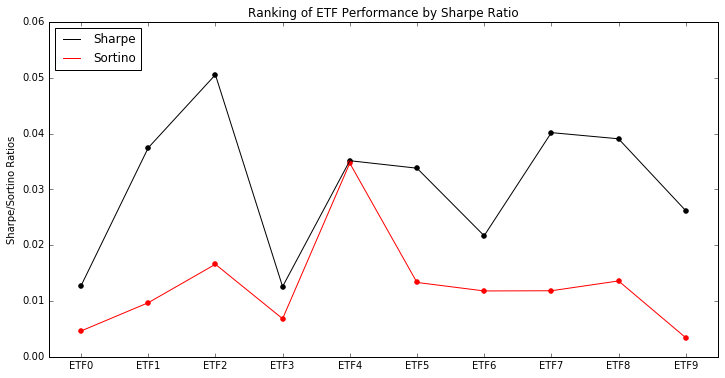

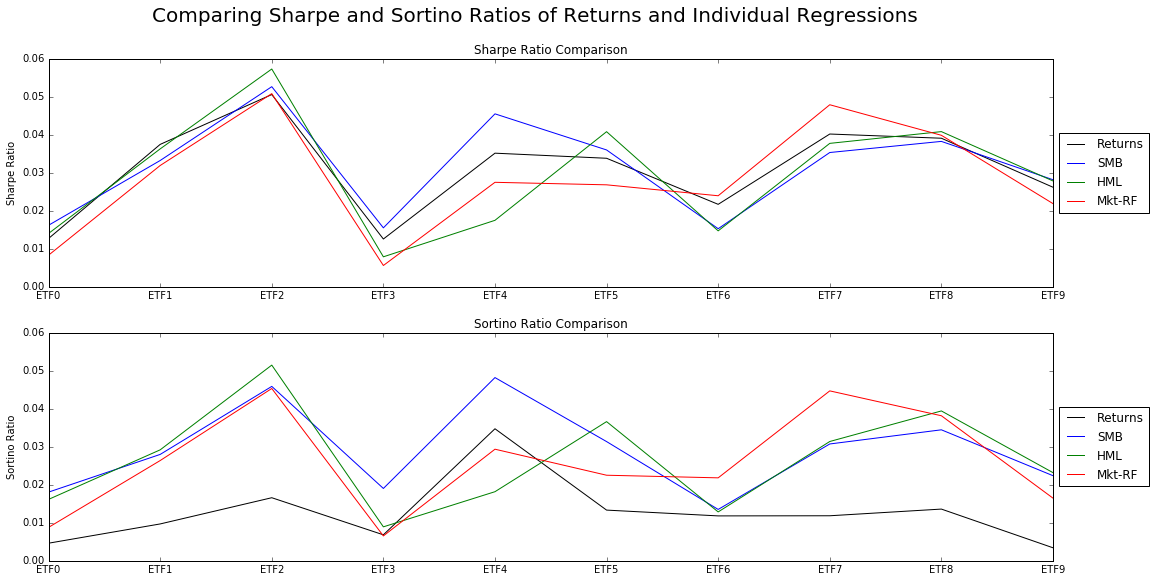

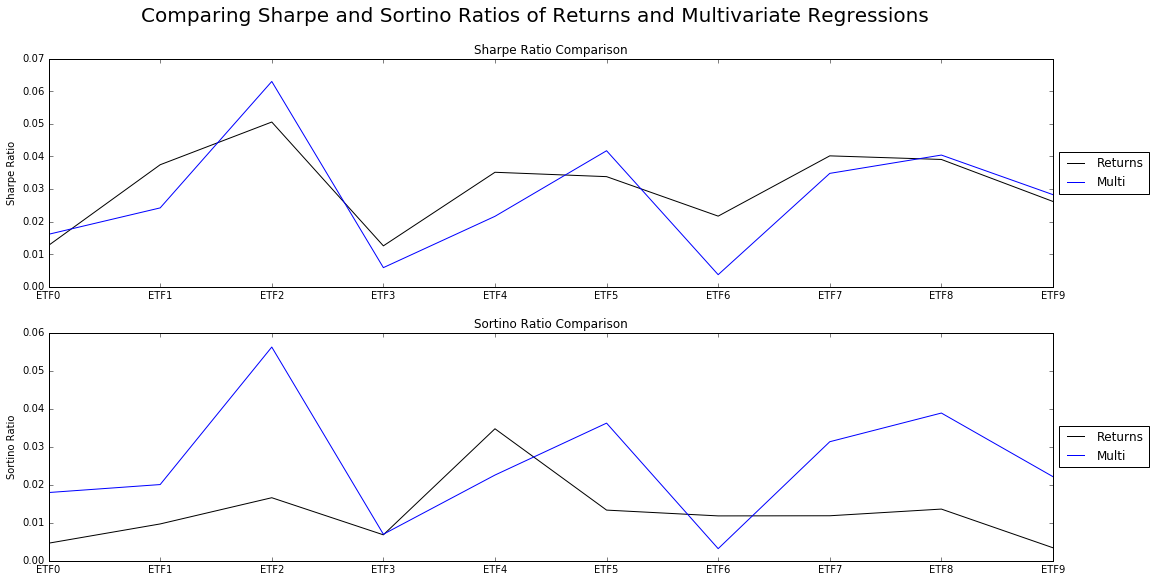

In [40]:
# plots
x_ax = np.array([0,1,2,3,4,5,6,7,8,9]) # string axis

plt.figure(1,figsize=(12,6))
plt.xticks(x_ax,sims.index)
plt.title('Ranking of ETF Performance by Sharpe Ratio')
plt.ylabel('Sharpe/Sortino Ratios')
plt.plot(x_ax,Ratios.Sharpe,color='black')
plt.scatter(x_ax,Ratios.Sharpe,color='black')
plt.plot(x_ax,Ratios.Sortino,color='red')
plt.scatter(x_ax,Ratios.Sortino,color='red')
plt.legend(['Sharpe','Sortino'],loc='upper left')

plt.figure(2,figsize=(18,9))
plt.suptitle('Comparing Sharpe and Sortino Ratios of Returns and Individual Regressions',fontsize=20)
plt.subplot(211)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sharpe'],color='black')
plt.plot(x_ax,Indiv['SMB Sharpe'])
plt.plot(x_ax,Indiv['HML Sharpe'])
plt.plot(x_ax,Indiv['Mkt-RF Sharpe'])
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.legend(['Returns','SMB','HML','Mkt-RF'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.subplot(212)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sortino'],color='black')
plt.plot(x_ax,Indiv['SMB Sortino'])
plt.plot(x_ax,Indiv['HML Sortino'])
plt.plot(x_ax,Indiv['Mkt-RF Sortino'])
plt.title('Sortino Ratio Comparison')
plt.ylabel('Sortino Ratio')
plt.legend(['Returns','SMB','HML','Mkt-RF'],loc='center left',bbox_to_anchor=(1, 0.5))

plt.figure(3,figsize=(18,9))
x_ax = np.array([0,1,2,3,4,5,6,7,8,9])
plt.suptitle('Comparing Sharpe and Sortino Ratios of Returns and Multivariate Regressions',fontsize=20)
plt.subplot(211)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sharpe'],color='black')
plt.plot(x_ax,Multi['Sharpe'])
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.legend(['Returns','Multi'],loc='center left',bbox_to_anchor=(1, 0.5))
plt.subplot(212)
plt.xticks(x_ax,sims.index)
plt.plot(x_ax,Ratios['Sortino'],color='black')
plt.plot(x_ax,Multi['Sortino'])
plt.title('Sortino Ratio Comparison')
plt.ylabel('Sortino Ratio')
plt.legend(['Returns','Multi'],loc='center left',bbox_to_anchor=(1, 0.5))


In [38]:
# improvement individual regressions
Improv_Indiv = pd.DataFrame()
Improv_Indiv['SMB Sharpe'] = Indiv['SMB Sharpe'] - Ratios['Sharpe']
Improv_Indiv['SMB Sortino'] = Indiv['SMB Sortino'] - Ratios['Sortino']
Improv_Indiv['HML Sharpe'] = Indiv['HML Sharpe'] - Ratios['Sharpe']
Improv_Indiv['HML Sortino'] = Indiv['HML Sortino'] - Ratios['Sortino']
Improv_Indiv['RF Sharpe'] = Indiv['RF Sharpe'] - Ratios['Sharpe']
Improv_Indiv['RF Sortino'] = Indiv['RF Sortino'] - Ratios['Sortino']
Improv_Indiv['Mkt-RF Sharpe'] = Indiv['Mkt-RF Sharpe'] - Ratios['Sharpe']
Improv_Indiv['Mkt-RF Sortino'] = Indiv['Mkt-RF Sortino'] - Ratios['Sortino']
Improv_Indiv = Improv_Indiv.set_index(sims.index)
print(Improv_Indiv)

      SMB Sharpe  SMB Sortino  HML Sharpe  HML Sortino  RF Sharpe  RF Sortino  \
ETF0    0.003474     0.013430    0.001321     0.011515   0.000012           0   
ETF1   -0.004236     0.018273   -0.001182     0.019477   0.000011           0   
ETF2    0.002070     0.029261    0.006713     0.034855  -0.000014           0   
ETF3    0.002934     0.012188   -0.004679     0.002096   0.000012           0   
ETF4    0.010335     0.013455   -0.017650    -0.016541   0.000013           0   
ETF5    0.002186     0.018012    0.006989     0.023258   0.000014           0   
ETF6   -0.006405     0.001699   -0.006970     0.001048   0.000017           0   
ETF7   -0.004860     0.018870   -0.002456     0.019520   0.000008           0   
ETF8   -0.000832     0.020836    0.001738     0.025798   0.000009           0   
ETF9    0.001970     0.018946    0.001652     0.019749   0.000017           0   

      Mkt-RF Sharpe  Mkt-RF Sortino  
ETF0      -0.004388        0.004161  
ETF1      -0.005552        0.016

In [39]:
# improvement multivariate regressions
Improv_Multi = pd.DataFrame()
Improv_Multi['Sharpe'] = Multi['Sharpe'] - Ratios['Sharpe']
Improv_Multi['Sortino'] = Multi['Sortino'] - Ratios['Sortino']
Improv_Multi = Improv_Multi.set_index(sims.index)
print(Improv_Multi)

        Sharpe   Sortino
ETF0  0.003403  0.013315
ETF1 -0.013232  0.010352
ETF2  0.012439  0.039600
ETF3 -0.006680  0.000152
ETF4 -0.013507 -0.012165
ETF5  0.007943  0.022862
ETF6 -0.017956 -0.008612
ETF7 -0.005372  0.019460
ETF8  0.001349  0.025242
ETF9  0.002089  0.018690
